In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import norm
from tqdm import trange, tqdm_notebook, tqdm

import math

from collections import OrderedDict


import scanpy as sc
import os


In [2]:
## Load adipose data
UCE_filtered_DIR = '/home/syyang/GitRepo/cs294/finalproject/data/UCEgenes_anndata'

adipose_sn_file = 'adata_with_infer_multiresleiden_toR_Xastypeinteger_proc.h5ad'
adipose_sn_ad = sc.read_h5ad(os.path.join(UCE_filtered_DIR,  adipose_sn_file) )

adipose_sn_ad.obs['sample'] = adipose_sn_ad.obs['sample'].astype('category')
adipose_sn_ad.obs['leiden_scVI_res0.9'] = adipose_sn_ad.obs['leiden_scVI_res0.9'].astype('category')

In [79]:
class scDataset(Dataset):
    def __init__(self, adata):
        """
        adata: AnnData object
        cat: from adata.obs['sample']
        labels: from adata.obs['leiden_scVI_res0.9'] --> Need to be changed to cell type
        """
        self.obs = adata.obs
        self.data = torch.log(torch.tensor(adata.layers['counts'].toarray() + 1. ))  # log transform
        #self.data =  torch.tensor(adata.layers['counts'].toarray())
        self.local_library_mean = self.data.sum(axis=1)
        self.local_library_var = torch.tensor([1.])
        
        self.cat = torch.tensor(adata.obs['sample'].cat.codes.values).to(torch.int64) # sample labels
        self.n_cat = adata.obs['sample'].nunique()
        self.labels = torch.tensor(adata.obs['leiden_scVI_res0.9'].cat.codes.values).to(torch.int64)   # cell type labels
        self.n_labels = adata.obs['leiden_scVI_res0.9'].nunique()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # onehot encode `cat` and `labels`
        cat_onehot = F.one_hot(self.cat[idx], self.n_cat)
        label_onehot = F.one_hot(self.labels[idx], self.n_labels)
        
        return self.data[idx], cat_onehot, label_onehot, self.local_library_mean[idx], self.local_library_var 
    

# Example
adipose_dataset = scDataset(adipose_sn_ad)
data_loader = DataLoader(adipose_dataset, batch_size=10, shuffle=False)
a = next(iter(data_loader))
    

In [80]:
class LinearBlock(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0.1):
        super(LinearBlock, self).__init__()
        layers = [
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim, momentum=.01, eps=0.001),
            nn.ReLU(),
        ]
        if dropout:
            layers.append(nn.Dropout(p=dropout))
            
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

class Encoder_x(nn.Module):
    """_summary_
        This encodes the latent space of the data vector x
    Args:
        nn (_type_): _description_
        latent_dim: 1280, same as the latent_dim in the UCE model (UCE: \ref[Rosen, Yanay, et al. "Universal Cell Embeddings: A Foundation Model for Cell Biology." bioRxiv (2023): 2023-11.])
        
    """
    def __init__(self, input_dim, latent_dim=1280, hidden_dim=1280, hidden_layers=2):
        super(Encoder_x, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[latent_dim, latent_dim]] * (hidden_layers -2) + [[hidden_dim, latent_dim]]
        self.layers = nn.Sequential(
            *[LinearBlock(dim[0], dim[1]) for dim in layer_dims]
        )
        self.linear_mean = nn.Linear(latent_dim, latent_dim)
        self.linear_var = nn.Linear(latent_dim, latent_dim)

    def forward(self, x, cell_type_one_hot):
        x = torch.cat([x, cell_type_one_hot], dim=1) # cell_type_one_hot is the one_hot encoded cell_type_index  
        x = self.layers(x)
        qz_mean = self.linear_mean(x)
        qz_var = torch.exp(self.linear_var(x))
        #z_dist = torch.distributions.Normal(qz_mean, qz_var.sqrt())
        return qz_mean, qz_var #, z_dist
    
    
class Encoder_l(nn.Module):
    """_summary_
        This encodes the library size, which is affected by observation x 
        
    Args:
        nn (_type_): _description_
        latent_dim: 1
        
    """
    def __init__(self, input_dim, latent_dim=1, hidden_dim=20, hidden_layers=2):
        super(Encoder_l, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[latent_dim, latent_dim]] * (hidden_layers -2) + [[hidden_dim, latent_dim]]
        self.layers = nn.Sequential(
            *[LinearBlock(dim[0], dim[1]) for dim in layer_dims]
        )
        self.linear_mean = nn.Linear(latent_dim, latent_dim)
        self.linear_var = nn.Linear(latent_dim, latent_dim)

    def forward(self, x):
        x = self.layers(x)
        ql_mean = self.linear_mean(x)
        ql_var = torch.exp(self.linear_var(x))
        #library_dist = torch.distributions.Normal(ql_mean, ql_var.sqrt())
        return ql_mean, ql_var #, library_dist
    

    
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=1280, hidden_layers=2):
        super(Decoder, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -1) 
        self.decoder = nn.Sequential(
            *[LinearBlock(dim[0], dim[1], dropout=None) for dim in layer_dims]
        )
        
        self.px_dropout_decoder = nn.Sequential(nn.Linear(hidden_dim, output_dim))  # the logit of the dropout rate
        self.px_scale_decoder = nn.Sequential(nn.Linear(hidden_dim, output_dim),
                                      nn.Softmax(dim=-1))
        self.px_dispersion_decoder = nn.Sequential(nn.Linear(hidden_dim, output_dim),
                                                   nn.ReLU())
        

    def forward(self, z, library, cat_one_hot):
        
        input = torch.cat([z, cat_one_hot], dim=1) # cat_index is the one_hot encoded cell_type_index
        x = self.decoder(input)
        
        px_scale = self.px_scale_decoder(x)
        #px_rate = torch.exp(library) * px_scale  # encode library size
        px_rate = library * px_scale  # use observed library size

        
        px_dispersion = self.px_dispersion_decoder(x)
        
        px_dropout = self.px_dropout_decoder(x)
        
        return px_rate, px_dispersion, px_dropout 
    
    

    
def log_zinb_positive(
    x: torch.Tensor,
    mu: torch.Tensor,
    theta: torch.Tensor,
    pi: torch.Tensor,
    eps: float = 1e-8,
) -> torch.Tensor:
    """
    Adapted From `https://github.com/scverse/scvi-tools`  with minor modifications
     
    Log likelihood (scalar) of a minibatch according to a zinb model.

    Parameters
    ----------
    x
        Data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    pi
        logit of the dropout parameter (real support) (shape: minibatch x vars)
    eps
        numerical stability constant

    Notes
    -----
    We parametrize the bernoulli using the logits, hence the softplus functions appearing.
    """
    # theta is the dispersion rate. If .ndimension() == 1, it is shared for all cells (regardless
    # of batch or labels)
    if theta.ndimension() == 1:
        theta = theta.view(1, theta.size(0))  # In this case, we reshape theta for broadcasting

    # Uses log(sigmoid(x)) = -softplus(-x)
    softplus_pi = F.softplus(-pi)
    log_theta_eps = torch.log(theta + eps)
    log_theta_mu_eps = torch.log(theta + mu + eps)
    pi_theta_log = -pi + theta * (log_theta_eps - log_theta_mu_eps)

    case_zero = F.softplus(pi_theta_log) - softplus_pi
    mul_case_zero = torch.mul((x < eps).type(torch.float32), case_zero)

    case_non_zero = (
        -softplus_pi
        + pi_theta_log
        + x * (torch.log(mu + eps) - log_theta_mu_eps)
        + torch.nan_to_num(torch.lgamma(x + theta), posinf=0.)
        - torch.nan_to_num(torch.lgamma(theta), posinf=0.)
        - torch.lgamma(x + 1)
    )
    mul_case_non_zero = torch.mul((x > eps).type(torch.float32), case_non_zero)
    

    # print(f"x[0, 0] is: {x[0,0]}")
    # print(f"torch.lgamma(x + theta)[0, 0] is: {torch.lgamma(x + theta)[0,0]}")
    # print(f"torch.lgamma(theta)[0, 0] is: {torch.lgamma(theta)[0,0]}")

    res = mul_case_zero + mul_case_non_zero

    return res



def log_nb_positive(
    x: torch.Tensor ,
    mu: torch.Tensor ,
    theta: torch.Tensor ,
    eps: float = 1e-8,
    log_fn: callable = torch.log,
    lgamma_fn: callable = torch.lgamma,
) -> torch.Tensor :
    """Log likelihood (scalar) of a minibatch according to a nb model.

    Parameters
    ----------
    x
        data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    eps
        numerical stability constant
    log_fn
        log function
    lgamma_fn
        log gamma function
    """
    log = log_fn
    lgamma = lgamma_fn
    log_theta_mu_eps = log(theta + mu + eps)
    res = (
        theta * (log(theta + eps) - log_theta_mu_eps)
        + x * (log(mu + eps) - log_theta_mu_eps)
        + lgamma(x + theta)
        - lgamma(theta)
        - lgamma(x + 1)
    )

    return res


In [81]:
class snRNAseqVAE(nn.Module):
    def __init__(self, input_dim, output_dim, latent_dim, total_cat, total_cell_type):
        super(snRNAseqVAE, self).__init__()

        self.total_cat = total_cat
        self.total_cell_type = total_cell_type # total_cell_type = total-known-cell-types + 1 (for unknown cell type: 0) 
        
        #self.reconst_loss_fun = -log_zinb_positive
        
        encoder_x_input_dim = input_dim + total_cell_type
        self.encoder_x = Encoder_x(encoder_x_input_dim, latent_dim)
        
        #self.encoder_l = Encoder_l(input_dim, 1)
        
        decoder_input_dim = latent_dim + total_cat  # total_cat is the total number of categories in the cat_index, indicates datasets 
        self.decoder = Decoder(decoder_input_dim, output_dim)
        
    def _inference(self, x, cat_one_hot, cell_type_one_hot, l):
        qz_mean, qz_var = self.encoder_x(x, cell_type_one_hot)
        #ql_mean, ql_var = self.encoder_l(x)
        z = torch.distributions.Normal(qz_mean, qz_var.sqrt()).rsample()
        #l = torch.distributions.Normal(ql_mean, ql_var.sqrt()).rsample()
        px_rate, px_dispersion, px_dropout  = self.decoder(z, l, cat_one_hot)
        #return qz_mean, qz_var, ql_mean, ql_var, px_rate, px_dispersion, px_dropout  # encode library size 
        return qz_mean, qz_var, px_rate, px_dispersion, px_dropout 
    
    
    def forward(self, x, local_l_mean, local_l_var, cat_one_hot, cell_type_one_hot):
        """_summary_

        Args:
            x (_type_): _description_
            local_l_mean (_type_): shape of [batch_size, 1]
            local_l_var (_type_): shape of [batch_size, 1]
            cat_one_hot (_type_): shape of [batch_size, n_cat]
            cell_type_one_hot (_type_): shape of [batch_size, n_cell_types]

        Returns:
            _type_: _description_
        """
        #local_l_mean =  x.sum(axis=1) outside of this function
        #local_l_var = 0 # should this be within batch? YES as it is observed and varies from batch to batch. FInish outside of this function

        
        #qz_mean, qz_var, ql_mean, ql_var, px_rate, px_dispersion, px_dropout = self._inference(x, cat_one_hot, cell_type_one_hot)  # encode library size output 
        qz_mean, qz_var, px_rate, px_dispersion, px_dropout = self._inference(x, cat_one_hot, cell_type_one_hot, local_l_mean)
        
        z_dist = torch.distributions.Normal(qz_mean, qz_var.sqrt())
        #l_dist = torch.distributions.Normal(ql_mean, ql_var)
        kl_z = torch.distributions.kl.kl_divergence(z_dist, torch.distributions.Normal(torch.zeros_like(qz_mean), torch.ones_like(qz_var))).sum(axis=1)
        #kl_l = torch.distributions.kl.kl_divergence(l_dist, torch.distributions.Normal(local_l_mean, local_l_var.sqrt())).sum(axis=1)
        #kl_l = torch.tensor([0.])
        
        reconst_loss = -log_zinb_positive(x, px_rate, px_dispersion, px_dropout).mean(axis=-1)
        # print(f"reconst_loss is {reconst_loss}")
        # print(f"reconst_loss shape if of: {reconst_loss.shape}")
        # print(f"kl_z shape if of: {kl_z.shape}")
        # print(f"kl_l shape if of: {kl_l.shape}")
        
        #return (reconst_loss + kl_z + kl_l).mean() #, reconst_loss.mean(), kl_z.mean(), kl_l.mean()
        return (reconst_loss + kl_z ).mean()

#### Change to code cell to run 
#### DEBUGGING
###### prepare data
total_cat = adipose_dataset.obs['sample'].nunique()
total_cell_type = adipose_dataset.obs['leiden_scVI_res0.9'].nunique()
output_dim  = adipose_dataset.data.shape[1]
model = snRNAseqVAE(input_dim=adipose_dataset.data.shape[1], output_dim=output_dim, \
    latent_dim=1280, total_cat=total_cat, total_cell_type=total_cell_type)

optimizer = optim.Adam(model.parameters(), lr=1e-3, eps=0.01)

x, cat_onehot, label_onehot, local_library_mean, local_library_var = next(iter(data_loader))

loss = model(x, local_library_mean, local_library_var, cat_onehot, label_onehot)

for i in loss:
    print(i)

In [82]:
## Training 
def trainning(model, train_loader, device, optimizer, n_epochs=100):
    model = model.to(device)
    model.train()
    train_loss = []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_loss = 0
        N = 0
        for i, data in enumerate(train_loader):
            x, cat_onehot, label_onehot, local_library_mean, local_library_var = data
            
            x = x.to(device)
            cat_onehot = cat_onehot.to(device)
            label_onehot = label_onehot.to(device)
            local_library_mean = local_library_mean.to(device).view((-1,1))  # size of [batch_size, 1]
            local_library_var = local_library_var.to(device).view((-1,1))  # size of [batch_size, 1]
            
            optimizer.zero_grad()
            loss = model(x, local_library_mean, local_library_var, cat_onehot, label_onehot) 
            loss.backward()
            total_loss += loss.item() * x.size(0)
            N += x.size(0)
            optimizer.step()
        print("Epoch: ", epoch, "Loss: ", train_loss/N )
        train_loss.append(total_loss/N)
        
    return train_loss

In [83]:
adipose_sn_ad.obs['sample'].unique()
adipose_sn_ad[adipose_sn_ad.obs['sample'] == '03_SQ', ].shape

(823, 15064)

In [90]:
## Data
train_data = adipose_sn_ad#[adipose_sn_ad.obs['sample'] == '03_SQ', ]
adipose_dataset = scDataset(train_data)
data_loader = DataLoader(adipose_dataset, batch_size=500, shuffle=True)

## set model 
total_cat = adipose_dataset.obs['sample'].nunique()
total_cell_type = adipose_dataset.obs['leiden_scVI_res0.9'].nunique()
output_dim  = adipose_dataset.data.shape[1]
model = snRNAseqVAE(input_dim=adipose_dataset.data.shape[1], output_dim=output_dim, \
    latent_dim=30, total_cat=total_cat, total_cell_type=total_cell_type)

optimizer = optim.Adam(model.parameters(), lr=1e-3, eps=0.01)

train_loss = trainning(model, data_loader, device='cuda', optimizer=optimizer, n_epochs=400)

  0%|          | 1/400 [00:03<20:12,  3.04s/it]

Epoch:  0 Loss:  0.4370010197162628


  0%|          | 2/400 [00:06<20:45,  3.13s/it]

Epoch:  1 Loss:  0.36626189947128296


  1%|          | 3/400 [00:09<20:33,  3.11s/it]

Epoch:  2 Loss:  0.3488491475582123


  1%|          | 4/400 [00:12<20:19,  3.08s/it]

Epoch:  3 Loss:  0.3259769380092621


  1%|▏         | 5/400 [00:15<20:30,  3.12s/it]

Epoch:  4 Loss:  0.31800273060798645


  2%|▏         | 6/400 [00:18<20:34,  3.13s/it]

Epoch:  5 Loss:  0.31745150685310364


  2%|▏         | 7/400 [00:21<20:24,  3.11s/it]

Epoch:  6 Loss:  0.3146733343601227


  2%|▏         | 8/400 [00:24<20:14,  3.10s/it]

Epoch:  7 Loss:  0.30540746450424194


  2%|▏         | 9/400 [00:28<20:22,  3.13s/it]

Epoch:  8 Loss:  0.28801053762435913


  2%|▎         | 10/400 [00:31<20:08,  3.10s/it]

Epoch:  9 Loss:  0.3098895251750946


  3%|▎         | 11/400 [00:34<20:18,  3.13s/it]

Epoch:  10 Loss:  0.31341812014579773


  3%|▎         | 12/400 [00:37<20:04,  3.10s/it]

Epoch:  11 Loss:  0.2981625199317932


  3%|▎         | 13/400 [00:40<19:53,  3.08s/it]

Epoch:  12 Loss:  0.3103703260421753


  4%|▎         | 14/400 [00:43<20:01,  3.11s/it]

Epoch:  13 Loss:  0.2909429967403412


  4%|▍         | 15/400 [00:46<19:47,  3.08s/it]

Epoch:  14 Loss:  0.29063960909843445


  4%|▍         | 16/400 [00:49<19:54,  3.11s/it]

Epoch:  15 Loss:  0.292733371257782


  4%|▍         | 17/400 [00:52<19:40,  3.08s/it]

Epoch:  16 Loss:  0.2800538241863251


  4%|▍         | 18/400 [00:55<19:49,  3.11s/it]

Epoch:  17 Loss:  0.2666366398334503


  5%|▍         | 19/400 [00:58<19:35,  3.08s/it]

Epoch:  18 Loss:  0.289612352848053


  5%|▌         | 20/400 [01:01<19:25,  3.07s/it]

Epoch:  19 Loss:  0.2853739559650421


  5%|▌         | 21/400 [01:05<19:34,  3.10s/it]

Epoch:  20 Loss:  0.2960883677005768


  6%|▌         | 22/400 [01:08<19:41,  3.13s/it]

Epoch:  21 Loss:  0.25363218784332275


  6%|▌         | 23/400 [01:11<19:28,  3.10s/it]

Epoch:  22 Loss:  0.2761594355106354


  6%|▌         | 24/400 [01:14<19:18,  3.08s/it]

Epoch:  23 Loss:  0.25955429673194885


  6%|▋         | 25/400 [01:17<19:28,  3.12s/it]

Epoch:  24 Loss:  0.25484350323677063


  6%|▋         | 26/400 [01:20<19:16,  3.09s/it]

Epoch:  25 Loss:  0.26552844047546387


  7%|▋         | 27/400 [01:23<19:23,  3.12s/it]

Epoch:  26 Loss:  0.2777548134326935


  7%|▋         | 28/400 [01:26<19:10,  3.09s/it]

Epoch:  27 Loss:  0.2526198625564575


  7%|▋         | 29/400 [01:29<19:01,  3.08s/it]

Epoch:  28 Loss:  0.272003710269928


  8%|▊         | 30/400 [01:33<19:09,  3.11s/it]

Epoch:  29 Loss:  0.25804659724235535


  8%|▊         | 31/400 [01:36<19:01,  3.09s/it]

Epoch:  30 Loss:  0.2665345370769501


  8%|▊         | 32/400 [01:39<19:09,  3.12s/it]

Epoch:  31 Loss:  0.26553210616111755


  8%|▊         | 33/400 [01:42<18:56,  3.10s/it]

Epoch:  32 Loss:  0.27716150879859924


  8%|▊         | 34/400 [01:45<19:03,  3.12s/it]

Epoch:  33 Loss:  0.2643561065196991


  9%|▉         | 35/400 [01:48<18:50,  3.10s/it]

Epoch:  34 Loss:  0.27110347151756287


  9%|▉         | 36/400 [01:51<18:40,  3.08s/it]

Epoch:  35 Loss:  0.264711856842041


  9%|▉         | 37/400 [01:54<18:49,  3.11s/it]

Epoch:  36 Loss:  0.268583744764328


 10%|▉         | 38/400 [01:57<18:38,  3.09s/it]

Epoch:  37 Loss:  0.27048999071121216


 10%|▉         | 39/400 [02:01<18:45,  3.12s/it]

Epoch:  38 Loss:  0.25410041213035583


 10%|█         | 40/400 [02:04<18:33,  3.09s/it]

Epoch:  39 Loss:  0.26574134826660156


 10%|█         | 41/400 [02:07<18:56,  3.17s/it]

Epoch:  40 Loss:  0.25291380286216736


 10%|█         | 42/400 [02:10<18:39,  3.13s/it]

Epoch:  41 Loss:  0.25040140748023987


 11%|█         | 43/400 [02:13<18:26,  3.10s/it]

Epoch:  42 Loss:  0.260640949010849


 11%|█         | 44/400 [02:16<18:35,  3.13s/it]

Epoch:  43 Loss:  0.26673442125320435


 11%|█▏        | 45/400 [02:19<18:26,  3.12s/it]

Epoch:  44 Loss:  0.26305094361305237


 12%|█▏        | 46/400 [02:22<18:32,  3.14s/it]

Epoch:  45 Loss:  0.26138103008270264


 12%|█▏        | 47/400 [02:25<18:18,  3.11s/it]

Epoch:  46 Loss:  0.24829040467739105


 12%|█▏        | 48/400 [02:29<18:22,  3.13s/it]

Epoch:  47 Loss:  0.2461620420217514


 12%|█▏        | 49/400 [02:32<18:09,  3.10s/it]

Epoch:  48 Loss:  0.2630004584789276


 12%|█▎        | 50/400 [02:35<18:00,  3.09s/it]

Epoch:  49 Loss:  0.2524219751358032


 13%|█▎        | 51/400 [02:38<18:10,  3.12s/it]

Epoch:  50 Loss:  0.25158771872520447


 13%|█▎        | 52/400 [02:41<18:02,  3.11s/it]

Epoch:  51 Loss:  0.2648356854915619


 13%|█▎        | 53/400 [02:44<18:09,  3.14s/it]

Epoch:  52 Loss:  0.2539874315261841


 14%|█▎        | 54/400 [02:47<17:56,  3.11s/it]

Epoch:  53 Loss:  0.2719477415084839


 14%|█▍        | 55/400 [02:50<18:01,  3.13s/it]

Epoch:  54 Loss:  0.26531001925468445


 14%|█▍        | 56/400 [02:54<17:47,  3.10s/it]

Epoch:  55 Loss:  0.2582971155643463


 14%|█▍        | 57/400 [02:57<17:38,  3.09s/it]

Epoch:  56 Loss:  0.2573336660861969


 14%|█▍        | 58/400 [03:00<17:45,  3.12s/it]

Epoch:  57 Loss:  0.25612038373947144


 15%|█▍        | 59/400 [03:03<17:34,  3.09s/it]

Epoch:  58 Loss:  0.264508992433548


 15%|█▌        | 60/400 [03:06<17:40,  3.12s/it]

Epoch:  59 Loss:  0.24619224667549133


 15%|█▌        | 61/400 [03:09<17:44,  3.14s/it]

Epoch:  60 Loss:  0.25272902846336365


 16%|█▌        | 62/400 [03:12<17:35,  3.12s/it]

Epoch:  61 Loss:  0.2525893747806549


 16%|█▌        | 63/400 [03:16<17:54,  3.19s/it]

Epoch:  62 Loss:  0.2509419322013855


 16%|█▌        | 64/400 [03:19<17:37,  3.15s/it]

Epoch:  63 Loss:  0.24793307483196259


 16%|█▋        | 65/400 [03:22<17:39,  3.16s/it]

Epoch:  64 Loss:  0.24450363218784332


 16%|█▋        | 66/400 [03:25<17:24,  3.13s/it]

Epoch:  65 Loss:  0.2610841691493988


 17%|█▋        | 67/400 [03:28<17:29,  3.15s/it]

Epoch:  66 Loss:  0.2640199065208435


 17%|█▋        | 68/400 [03:31<17:15,  3.12s/it]

Epoch:  67 Loss:  0.2592325806617737


 17%|█▋        | 69/400 [03:34<17:05,  3.10s/it]

Epoch:  68 Loss:  0.2458917498588562


 18%|█▊        | 70/400 [03:37<17:11,  3.12s/it]

Epoch:  69 Loss:  0.2556706666946411


 18%|█▊        | 71/400 [03:40<16:59,  3.10s/it]

Epoch:  70 Loss:  0.2377299666404724


 18%|█▊        | 72/400 [03:44<17:03,  3.12s/it]

Epoch:  71 Loss:  0.2553858757019043


 18%|█▊        | 73/400 [03:47<16:52,  3.10s/it]

Epoch:  72 Loss:  0.25841668248176575


 18%|█▊        | 74/400 [03:50<16:57,  3.12s/it]

Epoch:  73 Loss:  0.2574787735939026


 19%|█▉        | 75/400 [03:53<16:46,  3.10s/it]

Epoch:  74 Loss:  0.25523293018341064


 19%|█▉        | 76/400 [03:56<16:36,  3.08s/it]

Epoch:  75 Loss:  0.2472858726978302


 19%|█▉        | 77/400 [03:59<16:42,  3.10s/it]

Epoch:  76 Loss:  0.23862117528915405


 20%|█▉        | 78/400 [04:02<16:32,  3.08s/it]

Epoch:  77 Loss:  0.25214332342147827


 20%|█▉        | 79/400 [04:05<16:38,  3.11s/it]

Epoch:  78 Loss:  0.24468205869197845


 20%|██        | 80/400 [04:08<16:28,  3.09s/it]

Epoch:  79 Loss:  0.24125434458255768


 20%|██        | 81/400 [04:11<16:33,  3.12s/it]

Epoch:  80 Loss:  0.24188010394573212


 20%|██        | 82/400 [04:15<16:25,  3.10s/it]

Epoch:  81 Loss:  0.24927985668182373


 21%|██        | 83/400 [04:18<16:16,  3.08s/it]

Epoch:  82 Loss:  0.2477319985628128


 21%|██        | 84/400 [04:21<16:23,  3.11s/it]

Epoch:  83 Loss:  0.25735369324684143


 21%|██▏       | 85/400 [04:24<16:14,  3.09s/it]

Epoch:  84 Loss:  0.24180644750595093


 22%|██▏       | 86/400 [04:27<16:05,  3.08s/it]

Epoch:  85 Loss:  0.26548972725868225


 22%|██▏       | 87/400 [04:30<16:13,  3.11s/it]

Epoch:  86 Loss:  0.23974032700061798


 22%|██▏       | 88/400 [04:33<16:17,  3.13s/it]

Epoch:  87 Loss:  0.2629898190498352


 22%|██▏       | 89/400 [04:36<16:11,  3.13s/it]

Epoch:  88 Loss:  0.24543976783752441


 22%|██▎       | 90/400 [04:39<16:05,  3.11s/it]

Epoch:  89 Loss:  0.23720888793468475


 23%|██▎       | 91/400 [04:43<16:14,  3.15s/it]

Epoch:  90 Loss:  0.24187800288200378


 23%|██▎       | 92/400 [04:46<16:05,  3.14s/it]

Epoch:  91 Loss:  0.25475791096687317


 23%|██▎       | 93/400 [04:49<16:11,  3.17s/it]

Epoch:  92 Loss:  0.2628048062324524


 24%|██▎       | 94/400 [04:52<16:00,  3.14s/it]

Epoch:  93 Loss:  0.240194633603096


 24%|██▍       | 95/400 [04:55<16:09,  3.18s/it]

Epoch:  94 Loss:  0.24409472942352295


 24%|██▍       | 96/400 [04:58<15:53,  3.14s/it]

Epoch:  95 Loss:  0.2379310429096222


 24%|██▍       | 97/400 [05:02<15:54,  3.15s/it]

Epoch:  96 Loss:  0.24840785562992096


 24%|██▍       | 98/400 [05:05<15:58,  3.17s/it]

Epoch:  97 Loss:  0.26004865765571594


 25%|██▍       | 99/400 [05:08<15:53,  3.17s/it]

Epoch:  98 Loss:  0.24682238698005676


 25%|██▌       | 100/400 [05:11<15:57,  3.19s/it]

Epoch:  99 Loss:  0.24281162023544312


 25%|██▌       | 101/400 [05:14<15:39,  3.14s/it]

Epoch:  100 Loss:  0.24159903824329376


 26%|██▌       | 102/400 [05:17<15:41,  3.16s/it]

Epoch:  101 Loss:  0.25447601079940796


 26%|██▌       | 103/400 [05:20<15:28,  3.13s/it]

Epoch:  102 Loss:  0.2446969598531723


 26%|██▌       | 104/400 [05:23<15:18,  3.10s/it]

Epoch:  103 Loss:  0.2471817284822464


 26%|██▋       | 105/400 [05:27<15:24,  3.13s/it]

Epoch:  104 Loss:  0.23560717701911926


 26%|██▋       | 106/400 [05:30<15:14,  3.11s/it]

Epoch:  105 Loss:  0.25128039717674255


 27%|██▋       | 107/400 [05:33<15:07,  3.10s/it]

Epoch:  106 Loss:  0.2626638114452362


 27%|██▋       | 108/400 [05:36<15:12,  3.12s/it]

Epoch:  107 Loss:  0.24705223739147186


 27%|██▋       | 109/400 [05:39<15:15,  3.15s/it]

Epoch:  108 Loss:  0.24797473847866058


 28%|██▊       | 110/400 [05:42<15:03,  3.12s/it]

Epoch:  109 Loss:  0.25399690866470337


 28%|██▊       | 111/400 [05:45<14:54,  3.09s/it]

Epoch:  110 Loss:  0.24418441951274872


 28%|██▊       | 112/400 [05:48<14:59,  3.12s/it]

Epoch:  111 Loss:  0.24304437637329102


 28%|██▊       | 113/400 [05:52<14:48,  3.10s/it]

Epoch:  112 Loss:  0.22572088241577148


 28%|██▊       | 114/400 [05:55<14:52,  3.12s/it]

Epoch:  113 Loss:  0.23600463569164276


 29%|██▉       | 115/400 [05:58<14:41,  3.09s/it]

Epoch:  114 Loss:  0.23552820086479187


 29%|██▉       | 116/400 [06:01<14:46,  3.12s/it]

Epoch:  115 Loss:  0.24225108325481415


 29%|██▉       | 117/400 [06:04<14:36,  3.10s/it]

Epoch:  116 Loss:  0.24376899003982544


 30%|██▉       | 118/400 [06:07<14:29,  3.08s/it]

Epoch:  117 Loss:  0.25412872433662415


 30%|██▉       | 119/400 [06:10<14:35,  3.11s/it]

Epoch:  118 Loss:  0.24206797778606415


 30%|███       | 120/400 [06:13<14:25,  3.09s/it]

Epoch:  119 Loss:  0.24539341032505035


 30%|███       | 121/400 [06:16<14:30,  3.12s/it]

Epoch:  120 Loss:  0.24237266182899475


 30%|███       | 122/400 [06:19<14:20,  3.09s/it]

Epoch:  121 Loss:  0.24995575845241547


 31%|███       | 123/400 [06:23<14:24,  3.12s/it]

Epoch:  122 Loss:  0.2378137856721878


 31%|███       | 124/400 [06:26<14:18,  3.11s/it]

Epoch:  123 Loss:  0.25416725873947144


 31%|███▏      | 125/400 [06:29<14:12,  3.10s/it]

Epoch:  124 Loss:  0.24453194439411163


 32%|███▏      | 126/400 [06:32<14:18,  3.13s/it]

Epoch:  125 Loss:  0.23582614958286285


 32%|███▏      | 127/400 [06:35<14:07,  3.11s/it]

Epoch:  126 Loss:  0.25818660855293274


 32%|███▏      | 128/400 [06:38<14:00,  3.09s/it]

Epoch:  127 Loss:  0.24030987918376923


 32%|███▏      | 129/400 [06:41<14:05,  3.12s/it]

Epoch:  128 Loss:  0.23053734004497528


 32%|███▎      | 130/400 [06:45<14:11,  3.15s/it]

Epoch:  129 Loss:  0.25787660479545593


 33%|███▎      | 131/400 [06:48<13:59,  3.12s/it]

Epoch:  130 Loss:  0.2348824292421341


 33%|███▎      | 132/400 [06:51<13:52,  3.11s/it]

Epoch:  131 Loss:  0.24839237332344055


 33%|███▎      | 133/400 [06:54<13:57,  3.13s/it]

Epoch:  132 Loss:  0.2448016107082367


 34%|███▎      | 134/400 [06:57<13:46,  3.11s/it]

Epoch:  133 Loss:  0.23959952592849731


 34%|███▍      | 135/400 [07:00<13:52,  3.14s/it]

Epoch:  134 Loss:  0.24786657094955444


 34%|███▍      | 136/400 [07:03<13:44,  3.12s/it]

Epoch:  135 Loss:  0.2376108467578888


 34%|███▍      | 137/400 [07:06<13:50,  3.16s/it]

Epoch:  136 Loss:  0.234389528632164


 34%|███▍      | 138/400 [07:09<13:39,  3.13s/it]

Epoch:  137 Loss:  0.24151645600795746


 35%|███▍      | 139/400 [07:13<13:30,  3.10s/it]

Epoch:  138 Loss:  0.24533957242965698


 35%|███▌      | 140/400 [07:16<13:37,  3.14s/it]

Epoch:  139 Loss:  0.2343727946281433


 35%|███▌      | 141/400 [07:19<13:33,  3.14s/it]

Epoch:  140 Loss:  0.24490448832511902


 36%|███▌      | 142/400 [07:22<13:40,  3.18s/it]

Epoch:  141 Loss:  0.22975024580955505


 36%|███▌      | 143/400 [07:25<13:26,  3.14s/it]

Epoch:  142 Loss:  0.23398789763450623


 36%|███▌      | 144/400 [07:28<13:30,  3.17s/it]

Epoch:  143 Loss:  0.24406521022319794


 36%|███▋      | 145/400 [07:31<13:18,  3.13s/it]

Epoch:  144 Loss:  0.2383548617362976


 36%|███▋      | 146/400 [07:35<13:09,  3.11s/it]

Epoch:  145 Loss:  0.24014291167259216


 37%|███▋      | 147/400 [07:38<13:12,  3.13s/it]

Epoch:  146 Loss:  0.241388738155365


 37%|███▋      | 148/400 [07:41<13:03,  3.11s/it]

Epoch:  147 Loss:  0.2489917129278183


 37%|███▋      | 149/400 [07:44<12:56,  3.09s/it]

Epoch:  148 Loss:  0.22712866961956024


 38%|███▊      | 150/400 [07:47<13:00,  3.12s/it]

Epoch:  149 Loss:  0.217196524143219


 38%|███▊      | 151/400 [07:50<13:03,  3.15s/it]

Epoch:  150 Loss:  0.23583060503005981


 38%|███▊      | 152/400 [07:53<12:53,  3.12s/it]

Epoch:  151 Loss:  0.2330484688282013


 38%|███▊      | 153/400 [07:56<12:46,  3.10s/it]

Epoch:  152 Loss:  0.236226424574852


 38%|███▊      | 154/400 [08:00<12:49,  3.13s/it]

Epoch:  153 Loss:  0.2407112866640091


 39%|███▉      | 155/400 [08:03<12:39,  3.10s/it]

Epoch:  154 Loss:  0.24009740352630615


 39%|███▉      | 156/400 [08:06<12:42,  3.12s/it]

Epoch:  155 Loss:  0.23896797001361847


 39%|███▉      | 157/400 [08:09<12:32,  3.10s/it]

Epoch:  156 Loss:  0.24154895544052124


 40%|███▉      | 158/400 [08:12<12:35,  3.12s/it]

Epoch:  157 Loss:  0.23324958980083466


 40%|███▉      | 159/400 [08:15<12:26,  3.10s/it]

Epoch:  158 Loss:  0.24650321900844574


 40%|████      | 160/400 [08:18<12:19,  3.08s/it]

Epoch:  159 Loss:  0.24026039242744446


 40%|████      | 161/400 [08:21<12:24,  3.12s/it]

Epoch:  160 Loss:  0.2286321520805359


 40%|████      | 162/400 [08:24<12:16,  3.09s/it]

Epoch:  161 Loss:  0.23433685302734375


 41%|████      | 163/400 [08:27<12:19,  3.12s/it]

Epoch:  162 Loss:  0.23240342736244202


 41%|████      | 164/400 [08:31<12:12,  3.11s/it]

Epoch:  163 Loss:  0.24435801804065704


 41%|████▏     | 165/400 [08:34<12:17,  3.14s/it]

Epoch:  164 Loss:  0.23221555352210999


 42%|████▏     | 166/400 [08:37<12:08,  3.11s/it]

Epoch:  165 Loss:  0.2324410378932953


 42%|████▏     | 167/400 [08:40<12:00,  3.09s/it]

Epoch:  166 Loss:  0.2485099881887436


 42%|████▏     | 168/400 [08:43<12:05,  3.13s/it]

Epoch:  167 Loss:  0.2350817173719406


 42%|████▏     | 169/400 [08:46<11:59,  3.11s/it]

Epoch:  168 Loss:  0.23983800411224365


 42%|████▎     | 170/400 [08:49<11:50,  3.09s/it]

Epoch:  169 Loss:  0.2421584576368332


 43%|████▎     | 171/400 [08:52<11:59,  3.14s/it]

Epoch:  170 Loss:  0.23622721433639526


 43%|████▎     | 172/400 [08:56<12:05,  3.18s/it]

Epoch:  171 Loss:  0.2422877699136734


 43%|████▎     | 173/400 [08:59<11:56,  3.16s/it]

Epoch:  172 Loss:  0.23142565786838531


 44%|████▎     | 174/400 [09:02<11:48,  3.13s/it]

Epoch:  173 Loss:  0.23348292708396912


 44%|████▍     | 175/400 [09:05<11:52,  3.17s/it]

Epoch:  174 Loss:  0.24050018191337585


 44%|████▍     | 176/400 [09:08<11:42,  3.14s/it]

Epoch:  175 Loss:  0.2381783276796341


 44%|████▍     | 177/400 [09:11<11:44,  3.16s/it]

Epoch:  176 Loss:  0.23774150013923645


 44%|████▍     | 178/400 [09:15<11:35,  3.13s/it]

Epoch:  177 Loss:  0.2522331178188324


 45%|████▍     | 179/400 [09:18<11:39,  3.16s/it]

Epoch:  178 Loss:  0.24575072526931763


 45%|████▌     | 180/400 [09:21<11:36,  3.17s/it]

Epoch:  179 Loss:  0.22539561986923218


 45%|████▌     | 181/400 [09:24<11:31,  3.16s/it]

Epoch:  180 Loss:  0.23164546489715576


 46%|████▌     | 182/400 [09:27<11:32,  3.18s/it]

Epoch:  181 Loss:  0.24356141686439514


 46%|████▌     | 183/400 [09:30<11:22,  3.15s/it]

Epoch:  182 Loss:  0.2555347681045532


 46%|████▌     | 184/400 [09:34<11:24,  3.17s/it]

Epoch:  183 Loss:  0.2330920398235321


 46%|████▋     | 185/400 [09:37<11:17,  3.15s/it]

Epoch:  184 Loss:  0.23105686902999878


 46%|████▋     | 186/400 [09:40<11:21,  3.19s/it]

Epoch:  185 Loss:  0.22919341921806335


 47%|████▋     | 187/400 [09:43<11:12,  3.16s/it]

Epoch:  186 Loss:  0.2310699075460434


 47%|████▋     | 188/400 [09:46<11:07,  3.15s/it]

Epoch:  187 Loss:  0.23283565044403076


 47%|████▋     | 189/400 [09:49<11:09,  3.17s/it]

Epoch:  188 Loss:  0.2370394468307495


 48%|████▊     | 190/400 [09:52<11:00,  3.14s/it]

Epoch:  189 Loss:  0.22919738292694092


 48%|████▊     | 191/400 [09:56<10:56,  3.14s/it]

Epoch:  190 Loss:  0.2332843393087387


 48%|████▊     | 192/400 [09:59<11:00,  3.18s/it]

Epoch:  191 Loss:  0.23429350554943085


 48%|████▊     | 193/400 [10:02<11:03,  3.21s/it]

Epoch:  192 Loss:  0.22676905989646912


 48%|████▊     | 194/400 [10:05<10:56,  3.19s/it]

Epoch:  193 Loss:  0.23114436864852905


 49%|████▉     | 195/400 [10:08<10:50,  3.18s/it]

Epoch:  194 Loss:  0.23500533401966095


 49%|████▉     | 196/400 [10:12<10:54,  3.21s/it]

Epoch:  195 Loss:  0.23210003972053528


 49%|████▉     | 197/400 [10:15<10:45,  3.18s/it]

Epoch:  196 Loss:  0.23520056903362274


 50%|████▉     | 198/400 [10:18<10:47,  3.20s/it]

Epoch:  197 Loss:  0.239463672041893


 50%|████▉     | 199/400 [10:21<10:39,  3.18s/it]

Epoch:  198 Loss:  0.23393012583255768


 50%|█████     | 200/400 [10:24<10:38,  3.19s/it]

Epoch:  199 Loss:  0.23909950256347656


 50%|█████     | 201/400 [10:28<10:31,  3.17s/it]

Epoch:  200 Loss:  0.22658194601535797


 50%|█████     | 202/400 [10:31<10:22,  3.14s/it]

Epoch:  201 Loss:  0.24292798340320587


 51%|█████     | 203/400 [10:34<10:24,  3.17s/it]

Epoch:  202 Loss:  0.256860613822937


 51%|█████     | 204/400 [10:37<10:16,  3.15s/it]

Epoch:  203 Loss:  0.22332991659641266


 51%|█████▏    | 205/400 [10:40<10:16,  3.16s/it]

Epoch:  204 Loss:  0.243891641497612


 52%|█████▏    | 206/400 [10:43<10:06,  3.12s/it]

Epoch:  205 Loss:  0.24007055163383484


 52%|█████▏    | 207/400 [10:46<10:07,  3.15s/it]

Epoch:  206 Loss:  0.23701880872249603


 52%|█████▏    | 208/400 [10:50<10:04,  3.15s/it]

Epoch:  207 Loss:  0.24338194727897644


 52%|█████▏    | 209/400 [10:53<09:57,  3.13s/it]

Epoch:  208 Loss:  0.23049810528755188


 52%|█████▎    | 210/400 [10:56<09:59,  3.16s/it]

Epoch:  209 Loss:  0.22950853407382965


 53%|█████▎    | 211/400 [10:59<09:55,  3.15s/it]

Epoch:  210 Loss:  0.24984683096408844


 53%|█████▎    | 212/400 [11:02<09:47,  3.13s/it]

Epoch:  211 Loss:  0.23585762083530426


 53%|█████▎    | 213/400 [11:05<09:49,  3.15s/it]

Epoch:  212 Loss:  0.22986598312854767


 54%|█████▎    | 214/400 [11:08<09:49,  3.17s/it]

Epoch:  213 Loss:  0.22003871202468872


 54%|█████▍    | 215/400 [11:12<09:40,  3.14s/it]

Epoch:  214 Loss:  0.218515545129776


 54%|█████▍    | 216/400 [11:15<09:34,  3.12s/it]

Epoch:  215 Loss:  0.2318030446767807


 54%|█████▍    | 217/400 [11:18<09:36,  3.15s/it]

Epoch:  216 Loss:  0.24127450585365295


 55%|█████▍    | 218/400 [11:21<09:29,  3.13s/it]

Epoch:  217 Loss:  0.24599067866802216


 55%|█████▍    | 219/400 [11:24<09:30,  3.15s/it]

Epoch:  218 Loss:  0.23610328137874603


 55%|█████▌    | 220/400 [11:27<09:22,  3.13s/it]

Epoch:  219 Loss:  0.22194239497184753


 55%|█████▌    | 221/400 [11:30<09:24,  3.15s/it]

Epoch:  220 Loss:  0.22816552221775055


 56%|█████▌    | 222/400 [11:33<09:14,  3.12s/it]

Epoch:  221 Loss:  0.23035117983818054


 56%|█████▌    | 223/400 [11:36<09:07,  3.09s/it]

Epoch:  222 Loss:  0.24905192852020264


 56%|█████▌    | 224/400 [11:40<09:11,  3.14s/it]

Epoch:  223 Loss:  0.23562270402908325


 56%|█████▋    | 225/400 [11:43<09:08,  3.13s/it]

Epoch:  224 Loss:  0.23964282870292664


 56%|█████▋    | 226/400 [11:46<09:07,  3.15s/it]

Epoch:  225 Loss:  0.2327709197998047


 57%|█████▋    | 227/400 [11:49<08:58,  3.11s/it]

Epoch:  226 Loss:  0.23134326934814453


 57%|█████▋    | 228/400 [11:52<08:59,  3.14s/it]

Epoch:  227 Loss:  0.232453390955925


 57%|█████▋    | 229/400 [11:55<08:51,  3.11s/it]

Epoch:  228 Loss:  0.23846466839313507


 57%|█████▊    | 230/400 [11:58<08:45,  3.09s/it]

Epoch:  229 Loss:  0.23458319902420044


 58%|█████▊    | 231/400 [12:02<08:47,  3.12s/it]

Epoch:  230 Loss:  0.23651443421840668


 58%|█████▊    | 232/400 [12:05<08:39,  3.09s/it]

Epoch:  231 Loss:  0.23296378552913666


 58%|█████▊    | 233/400 [12:08<08:36,  3.09s/it]

Epoch:  232 Loss:  0.23460622131824493


 58%|█████▊    | 234/400 [12:11<08:37,  3.12s/it]

Epoch:  233 Loss:  0.23487071692943573


 59%|█████▉    | 235/400 [12:14<08:38,  3.14s/it]

Epoch:  234 Loss:  0.2437058985233307


 59%|█████▉    | 236/400 [12:17<08:29,  3.11s/it]

Epoch:  235 Loss:  0.22449752688407898


 59%|█████▉    | 237/400 [12:20<08:22,  3.09s/it]

Epoch:  236 Loss:  0.22503535449504852


 60%|█████▉    | 238/400 [12:23<08:26,  3.13s/it]

Epoch:  237 Loss:  0.239658921957016


 60%|█████▉    | 239/400 [12:26<08:21,  3.11s/it]

Epoch:  238 Loss:  0.23716838657855988


 60%|██████    | 240/400 [12:30<08:22,  3.14s/it]

Epoch:  239 Loss:  0.2377970814704895


 60%|██████    | 241/400 [12:33<08:14,  3.11s/it]

Epoch:  240 Loss:  0.222223699092865


 60%|██████    | 242/400 [12:36<08:15,  3.13s/it]

Epoch:  241 Loss:  0.22745905816555023


 61%|██████    | 243/400 [12:39<08:07,  3.11s/it]

Epoch:  242 Loss:  0.24428091943264008


 61%|██████    | 244/400 [12:42<08:01,  3.09s/it]

Epoch:  243 Loss:  0.2337435930967331


 61%|██████▏   | 245/400 [12:45<08:03,  3.12s/it]

Epoch:  244 Loss:  0.24394424259662628


 62%|██████▏   | 246/400 [12:48<07:57,  3.10s/it]

Epoch:  245 Loss:  0.23074989020824432


 62%|██████▏   | 247/400 [12:51<07:58,  3.13s/it]

Epoch:  246 Loss:  0.23098911345005035


 62%|██████▏   | 248/400 [12:54<07:51,  3.10s/it]

Epoch:  247 Loss:  0.24266959726810455


 62%|██████▏   | 249/400 [12:58<07:51,  3.12s/it]

Epoch:  248 Loss:  0.21667808294296265


 62%|██████▎   | 250/400 [13:01<07:44,  3.10s/it]

Epoch:  249 Loss:  0.22154304385185242


 63%|██████▎   | 251/400 [13:04<07:38,  3.08s/it]

Epoch:  250 Loss:  0.22959329187870026


 63%|██████▎   | 252/400 [13:07<07:40,  3.11s/it]

Epoch:  251 Loss:  0.22796694934368134


 63%|██████▎   | 253/400 [13:10<07:33,  3.09s/it]

Epoch:  252 Loss:  0.22294171154499054


 64%|██████▎   | 254/400 [13:13<07:28,  3.07s/it]

Epoch:  253 Loss:  0.22296203672885895


 64%|██████▍   | 255/400 [13:16<07:30,  3.11s/it]

Epoch:  254 Loss:  0.23621369898319244


 64%|██████▍   | 256/400 [13:19<07:31,  3.13s/it]

Epoch:  255 Loss:  0.22167189419269562


 64%|██████▍   | 257/400 [13:22<07:25,  3.12s/it]

Epoch:  256 Loss:  0.23293788731098175


 64%|██████▍   | 258/400 [13:25<07:19,  3.09s/it]

Epoch:  257 Loss:  0.23527444899082184


 65%|██████▍   | 259/400 [13:29<07:22,  3.13s/it]

Epoch:  258 Loss:  0.2330361157655716


 65%|██████▌   | 260/400 [13:32<07:16,  3.12s/it]

Epoch:  259 Loss:  0.2330915778875351


 65%|██████▌   | 261/400 [13:35<07:19,  3.16s/it]

Epoch:  260 Loss:  0.22270828485488892


 66%|██████▌   | 262/400 [13:38<07:12,  3.13s/it]

Epoch:  261 Loss:  0.23296496272087097


 66%|██████▌   | 263/400 [13:41<07:13,  3.16s/it]

Epoch:  262 Loss:  0.22886715829372406


 66%|██████▌   | 264/400 [13:44<07:07,  3.14s/it]

Epoch:  263 Loss:  0.23423762619495392


 66%|██████▋   | 265/400 [13:47<07:01,  3.12s/it]

Epoch:  264 Loss:  0.23292064666748047


 66%|██████▋   | 266/400 [13:51<07:02,  3.15s/it]

Epoch:  265 Loss:  0.23011359572410583


 67%|██████▋   | 267/400 [13:54<06:56,  3.13s/it]

Epoch:  266 Loss:  0.2216825634241104


 67%|██████▋   | 268/400 [13:57<06:56,  3.16s/it]

Epoch:  267 Loss:  0.23853915929794312


 67%|██████▋   | 269/400 [14:00<06:50,  3.13s/it]

Epoch:  268 Loss:  0.23034018278121948


 68%|██████▊   | 270/400 [14:03<06:51,  3.16s/it]

Epoch:  269 Loss:  0.22948892414569855


 68%|██████▊   | 271/400 [14:06<06:42,  3.12s/it]

Epoch:  270 Loss:  0.23290514945983887


 68%|██████▊   | 272/400 [14:09<06:36,  3.09s/it]

Epoch:  271 Loss:  0.2290528118610382


 68%|██████▊   | 273/400 [14:12<06:36,  3.12s/it]

Epoch:  272 Loss:  0.227151021361351


 68%|██████▊   | 274/400 [14:16<06:30,  3.10s/it]

Epoch:  273 Loss:  0.2224666178226471


 69%|██████▉   | 275/400 [14:19<06:24,  3.08s/it]

Epoch:  274 Loss:  0.22141356766223907


 69%|██████▉   | 276/400 [14:22<06:25,  3.11s/it]

Epoch:  275 Loss:  0.23888249695301056


 69%|██████▉   | 277/400 [14:25<06:24,  3.13s/it]

Epoch:  276 Loss:  0.22778242826461792


 70%|██████▉   | 278/400 [14:28<06:18,  3.10s/it]

Epoch:  277 Loss:  0.23026897013187408


 70%|██████▉   | 279/400 [14:31<06:14,  3.10s/it]

Epoch:  278 Loss:  0.24010059237480164


 70%|███████   | 280/400 [14:34<06:16,  3.14s/it]

Epoch:  279 Loss:  0.23554812371730804


 70%|███████   | 281/400 [14:37<06:09,  3.10s/it]

Epoch:  280 Loss:  0.2310652881860733


 70%|███████   | 282/400 [14:40<06:08,  3.12s/it]

Epoch:  281 Loss:  0.21770694851875305


 71%|███████   | 283/400 [14:44<06:02,  3.10s/it]

Epoch:  282 Loss:  0.23030848801136017


 71%|███████   | 284/400 [14:47<06:03,  3.13s/it]

Epoch:  283 Loss:  0.2346838265657425


 71%|███████▏  | 285/400 [14:50<05:57,  3.11s/it]

Epoch:  284 Loss:  0.2357596606016159


 72%|███████▏  | 286/400 [14:53<05:51,  3.09s/it]

Epoch:  285 Loss:  0.2332349717617035


 72%|███████▏  | 287/400 [14:56<05:52,  3.12s/it]

Epoch:  286 Loss:  0.2326946258544922


 72%|███████▏  | 288/400 [14:59<05:46,  3.09s/it]

Epoch:  287 Loss:  0.22470782697200775


 72%|███████▏  | 289/400 [15:02<05:46,  3.12s/it]

Epoch:  288 Loss:  0.21227271854877472


 72%|███████▎  | 290/400 [15:05<05:40,  3.10s/it]

Epoch:  289 Loss:  0.24222327768802643


 73%|███████▎  | 291/400 [15:08<05:40,  3.13s/it]

Epoch:  290 Loss:  0.21969981491565704


 73%|███████▎  | 292/400 [15:12<05:35,  3.10s/it]

Epoch:  291 Loss:  0.23989108204841614


 73%|███████▎  | 293/400 [15:15<05:30,  3.08s/it]

Epoch:  292 Loss:  0.22098204493522644


 74%|███████▎  | 294/400 [15:18<05:30,  3.12s/it]

Epoch:  293 Loss:  0.21148158609867096


 74%|███████▍  | 295/400 [15:21<05:24,  3.09s/it]

Epoch:  294 Loss:  0.23653925955295563


 74%|███████▍  | 296/400 [15:24<05:19,  3.07s/it]

Epoch:  295 Loss:  0.23865921795368195


 74%|███████▍  | 297/400 [15:27<05:21,  3.12s/it]

Epoch:  296 Loss:  0.2414911538362503


 74%|███████▍  | 298/400 [15:30<05:21,  3.15s/it]

Epoch:  297 Loss:  0.2411438524723053


 75%|███████▍  | 299/400 [15:33<05:14,  3.11s/it]

Epoch:  298 Loss:  0.21542979776859283


 75%|███████▌  | 300/400 [15:36<05:08,  3.09s/it]

Epoch:  299 Loss:  0.23813338577747345


 75%|███████▌  | 301/400 [15:39<05:08,  3.11s/it]

Epoch:  300 Loss:  0.22160492837429047


 76%|███████▌  | 302/400 [15:43<05:02,  3.09s/it]

Epoch:  301 Loss:  0.22982850670814514


 76%|███████▌  | 303/400 [15:46<05:02,  3.12s/it]

Epoch:  302 Loss:  0.2371993213891983


 76%|███████▌  | 304/400 [15:49<04:57,  3.10s/it]

Epoch:  303 Loss:  0.23663201928138733


 76%|███████▋  | 305/400 [15:52<04:57,  3.13s/it]

Epoch:  304 Loss:  0.2300320714712143


 76%|███████▋  | 306/400 [15:55<04:51,  3.11s/it]

Epoch:  305 Loss:  0.2444675713777542


 77%|███████▋  | 307/400 [15:58<04:46,  3.08s/it]

Epoch:  306 Loss:  0.24439555406570435


 77%|███████▋  | 308/400 [16:01<04:46,  3.12s/it]

Epoch:  307 Loss:  0.2273707389831543


 77%|███████▋  | 309/400 [16:04<04:41,  3.09s/it]

Epoch:  308 Loss:  0.23134015500545502


 78%|███████▊  | 310/400 [16:07<04:40,  3.12s/it]

Epoch:  309 Loss:  0.22601066529750824


 78%|███████▊  | 311/400 [16:11<04:36,  3.11s/it]

Epoch:  310 Loss:  0.22932681441307068


 78%|███████▊  | 312/400 [16:14<04:36,  3.15s/it]

Epoch:  311 Loss:  0.2323346585035324


 78%|███████▊  | 313/400 [16:17<04:30,  3.11s/it]

Epoch:  312 Loss:  0.2321392446756363


 78%|███████▊  | 314/400 [16:20<04:25,  3.09s/it]

Epoch:  313 Loss:  0.23589299619197845


 79%|███████▉  | 315/400 [16:23<04:25,  3.12s/it]

Epoch:  314 Loss:  0.2330755889415741


 79%|███████▉  | 316/400 [16:26<04:20,  3.10s/it]

Epoch:  315 Loss:  0.21576274931430817


 79%|███████▉  | 317/400 [16:29<04:15,  3.08s/it]

Epoch:  316 Loss:  0.22864194214344025


 80%|███████▉  | 318/400 [16:32<04:15,  3.11s/it]

Epoch:  317 Loss:  0.22549059987068176


 80%|███████▉  | 319/400 [16:35<04:13,  3.14s/it]

Epoch:  318 Loss:  0.23659586906433105


 80%|████████  | 320/400 [16:39<04:08,  3.11s/it]

Epoch:  319 Loss:  0.22925445437431335


 80%|████████  | 321/400 [16:42<04:03,  3.09s/it]

Epoch:  320 Loss:  0.2241610884666443


 80%|████████  | 322/400 [16:45<04:03,  3.12s/it]

Epoch:  321 Loss:  0.2234463095664978


 81%|████████  | 323/400 [16:48<03:58,  3.09s/it]

Epoch:  322 Loss:  0.22731156647205353


 81%|████████  | 324/400 [16:51<03:57,  3.12s/it]

Epoch:  323 Loss:  0.23942819237709045


 81%|████████▏ | 325/400 [16:54<03:52,  3.10s/it]

Epoch:  324 Loss:  0.24003379046916962


 82%|████████▏ | 326/400 [16:57<03:51,  3.13s/it]

Epoch:  325 Loss:  0.22861932218074799


 82%|████████▏ | 327/400 [17:00<03:46,  3.11s/it]

Epoch:  326 Loss:  0.22929903864860535


 82%|████████▏ | 328/400 [17:03<03:41,  3.08s/it]

Epoch:  327 Loss:  0.23484526574611664


 82%|████████▏ | 329/400 [17:06<03:40,  3.11s/it]

Epoch:  328 Loss:  0.23847022652626038


 82%|████████▎ | 330/400 [17:10<03:36,  3.09s/it]

Epoch:  329 Loss:  0.22777830064296722


 83%|████████▎ | 331/400 [17:13<03:35,  3.12s/it]

Epoch:  330 Loss:  0.21939659118652344


 83%|████████▎ | 332/400 [17:16<03:30,  3.09s/it]

Epoch:  331 Loss:  0.22411483526229858


 83%|████████▎ | 333/400 [17:19<03:29,  3.12s/it]

Epoch:  332 Loss:  0.2305370718240738


 84%|████████▎ | 334/400 [17:22<03:24,  3.10s/it]

Epoch:  333 Loss:  0.2331722527742386


 84%|████████▍ | 335/400 [17:25<03:20,  3.08s/it]

Epoch:  334 Loss:  0.23985877633094788


 84%|████████▍ | 336/400 [17:28<03:19,  3.11s/it]

Epoch:  335 Loss:  0.24340316653251648


 84%|████████▍ | 337/400 [17:31<03:14,  3.10s/it]

Epoch:  336 Loss:  0.22664539515972137


 84%|████████▍ | 338/400 [17:34<03:11,  3.08s/it]

Epoch:  337 Loss:  0.22352679073810577


 85%|████████▍ | 339/400 [17:37<03:09,  3.11s/it]

Epoch:  338 Loss:  0.21888823807239532


 85%|████████▌ | 340/400 [17:41<03:08,  3.14s/it]

Epoch:  339 Loss:  0.22004801034927368


 85%|████████▌ | 341/400 [17:44<03:03,  3.12s/it]

Epoch:  340 Loss:  0.22061306238174438


 86%|████████▌ | 342/400 [17:47<03:00,  3.11s/it]

Epoch:  341 Loss:  0.2308487445116043


 86%|████████▌ | 343/400 [17:50<02:58,  3.13s/it]

Epoch:  342 Loss:  0.2380037009716034


 86%|████████▌ | 344/400 [17:53<02:53,  3.10s/it]

Epoch:  343 Loss:  0.231058269739151


 86%|████████▋ | 345/400 [17:56<02:51,  3.12s/it]

Epoch:  344 Loss:  0.2268093079328537


 86%|████████▋ | 346/400 [17:59<02:47,  3.10s/it]

Epoch:  345 Loss:  0.2357354611158371


 87%|████████▋ | 347/400 [18:02<02:45,  3.13s/it]

Epoch:  346 Loss:  0.2390417456626892


 87%|████████▋ | 348/400 [18:06<02:41,  3.10s/it]

Epoch:  347 Loss:  0.22088317573070526


 87%|████████▋ | 349/400 [18:09<02:37,  3.09s/it]

Epoch:  348 Loss:  0.23381900787353516


 88%|████████▊ | 350/400 [18:12<02:35,  3.12s/it]

Epoch:  349 Loss:  0.24075156450271606


 88%|████████▊ | 351/400 [18:15<02:31,  3.10s/it]

Epoch:  350 Loss:  0.2227754294872284


 88%|████████▊ | 352/400 [18:18<02:29,  3.12s/it]

Epoch:  351 Loss:  0.2275678962469101


 88%|████████▊ | 353/400 [18:21<02:25,  3.10s/it]

Epoch:  352 Loss:  0.23383966088294983


 88%|████████▊ | 354/400 [18:24<02:23,  3.12s/it]

Epoch:  353 Loss:  0.22160392999649048


 89%|████████▉ | 355/400 [18:27<02:19,  3.09s/it]

Epoch:  354 Loss:  0.22823412716388702


 89%|████████▉ | 356/400 [18:30<02:14,  3.07s/it]

Epoch:  355 Loss:  0.23164807260036469


 89%|████████▉ | 357/400 [18:33<02:13,  3.10s/it]

Epoch:  356 Loss:  0.2254556566476822


 90%|████████▉ | 358/400 [18:36<02:09,  3.09s/it]

Epoch:  357 Loss:  0.22640487551689148


 90%|████████▉ | 359/400 [18:40<02:06,  3.09s/it]

Epoch:  358 Loss:  0.22077910602092743


 90%|█████████ | 360/400 [18:43<02:05,  3.13s/it]

Epoch:  359 Loss:  0.2328786998987198


 90%|█████████ | 361/400 [18:46<02:03,  3.16s/it]

Epoch:  360 Loss:  0.24312500655651093


 90%|█████████ | 362/400 [18:49<01:58,  3.12s/it]

Epoch:  361 Loss:  0.23287618160247803


 91%|█████████ | 363/400 [18:52<01:54,  3.10s/it]

Epoch:  362 Loss:  0.2386290431022644


 91%|█████████ | 364/400 [18:55<01:52,  3.13s/it]

Epoch:  363 Loss:  0.231891468167305


 91%|█████████▏| 365/400 [18:58<01:48,  3.11s/it]

Epoch:  364 Loss:  0.24165242910385132


 92%|█████████▏| 366/400 [19:02<01:46,  3.13s/it]

Epoch:  365 Loss:  0.229176327586174


 92%|█████████▏| 367/400 [19:05<01:42,  3.10s/it]

Epoch:  366 Loss:  0.22743064165115356


 92%|█████████▏| 368/400 [19:08<01:40,  3.13s/it]

Epoch:  367 Loss:  0.23845095932483673


 92%|█████████▏| 369/400 [19:11<01:36,  3.11s/it]

Epoch:  368 Loss:  0.22254973649978638


 92%|█████████▎| 370/400 [19:14<01:32,  3.09s/it]

Epoch:  369 Loss:  0.2242504060268402


 93%|█████████▎| 371/400 [19:17<01:30,  3.12s/it]

Epoch:  370 Loss:  0.23299455642700195


 93%|█████████▎| 372/400 [19:20<01:27,  3.11s/it]

Epoch:  371 Loss:  0.22158107161521912


 93%|█████████▎| 373/400 [19:23<01:24,  3.14s/it]

Epoch:  372 Loss:  0.2203250527381897


 94%|█████████▎| 374/400 [19:26<01:20,  3.11s/it]

Epoch:  373 Loss:  0.23662658035755157


 94%|█████████▍| 375/400 [19:30<01:18,  3.14s/it]

Epoch:  374 Loss:  0.23251646757125854


 94%|█████████▍| 376/400 [19:33<01:14,  3.11s/it]

Epoch:  375 Loss:  0.22851374745368958


 94%|█████████▍| 377/400 [19:36<01:11,  3.09s/it]

Epoch:  376 Loss:  0.22138862311840057


 94%|█████████▍| 378/400 [19:39<01:08,  3.13s/it]

Epoch:  377 Loss:  0.23998720943927765


 95%|█████████▍| 379/400 [19:42<01:05,  3.11s/it]

Epoch:  378 Loss:  0.22729815542697906


 95%|█████████▌| 380/400 [19:45<01:01,  3.09s/it]

Epoch:  379 Loss:  0.23436486721038818


 95%|█████████▌| 381/400 [19:48<00:59,  3.12s/it]

Epoch:  380 Loss:  0.22853845357894897


 96%|█████████▌| 382/400 [19:51<00:56,  3.14s/it]

Epoch:  381 Loss:  0.2332633137702942


 96%|█████████▌| 383/400 [19:54<00:52,  3.11s/it]

Epoch:  382 Loss:  0.2270473688840866


 96%|█████████▌| 384/400 [19:58<00:49,  3.12s/it]

Epoch:  383 Loss:  0.21952372789382935


 96%|█████████▋| 385/400 [20:01<00:47,  3.15s/it]

Epoch:  384 Loss:  0.22403547167778015


 96%|█████████▋| 386/400 [20:04<00:43,  3.12s/it]

Epoch:  385 Loss:  0.23981982469558716


 97%|█████████▋| 387/400 [20:07<00:40,  3.14s/it]

Epoch:  386 Loss:  0.22961385548114777


 97%|█████████▋| 388/400 [20:10<00:37,  3.11s/it]

Epoch:  387 Loss:  0.22427310049533844


 97%|█████████▋| 389/400 [20:13<00:34,  3.14s/it]

Epoch:  388 Loss:  0.23688340187072754


 98%|█████████▊| 390/400 [20:16<00:31,  3.12s/it]

Epoch:  389 Loss:  0.2332172691822052


 98%|█████████▊| 391/400 [20:19<00:27,  3.10s/it]

Epoch:  390 Loss:  0.2294383943080902


 98%|█████████▊| 392/400 [20:23<00:25,  3.15s/it]

Epoch:  391 Loss:  0.2240314483642578


 98%|█████████▊| 393/400 [20:26<00:21,  3.11s/it]

Epoch:  392 Loss:  0.23801466822624207


 98%|█████████▊| 394/400 [20:29<00:18,  3.14s/it]

Epoch:  393 Loss:  0.2388186901807785


 99%|█████████▉| 395/400 [20:32<00:15,  3.11s/it]

Epoch:  394 Loss:  0.2157546877861023


 99%|█████████▉| 396/400 [20:35<00:12,  3.14s/it]

Epoch:  395 Loss:  0.23288510739803314


 99%|█████████▉| 397/400 [20:38<00:09,  3.11s/it]

Epoch:  396 Loss:  0.2243122011423111


100%|█████████▉| 398/400 [20:41<00:06,  3.09s/it]

Epoch:  397 Loss:  0.2287556529045105


100%|█████████▉| 399/400 [20:44<00:03,  3.13s/it]

Epoch:  398 Loss:  0.22393172979354858


100%|██████████| 400/400 [20:47<00:00,  3.12s/it]

Epoch:  399 Loss:  0.2181394398212433


In [91]:
# Get latent representation of the data
adipose_dataset = scDataset(train_data)
data_loader = DataLoader(adipose_dataset, batch_size=1000, shuffle=False)
z = []
with torch.no_grad():
    for i, data in enumerate(data_loader):
        x, cat_onehot, label_onehot, local_library_mean, local_library_var = data
        x = x.to('cuda')
        cat_onehot = cat_onehot.to('cuda')
        label_onehot = label_onehot.to('cuda')
        local_library_mean = local_library_mean.to('cuda').view((-1,1))
        local_library_var = local_library_var.to('cuda').view((-1,1))
        qz_mean, _ = model.encoder_x(x, label_onehot)
        z.append(qz_mean.cpu().detach())

In [92]:
train_data_2 = train_data.copy()
train_data_2.obsm['syy_VAE'] = torch.cat(z).numpy()
sc.pp.neighbors(train_data_2, use_rep='syy_VAE')

In [93]:
sc.tl.umap(train_data_2)

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


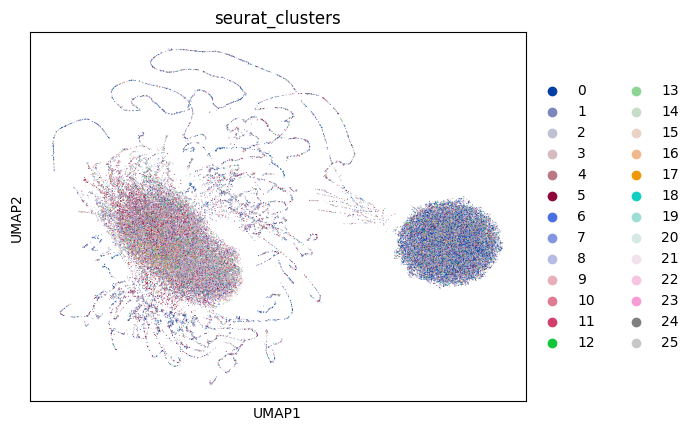

In [94]:
sc.pl.umap(train_data_2, color=['seurat_clusters'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


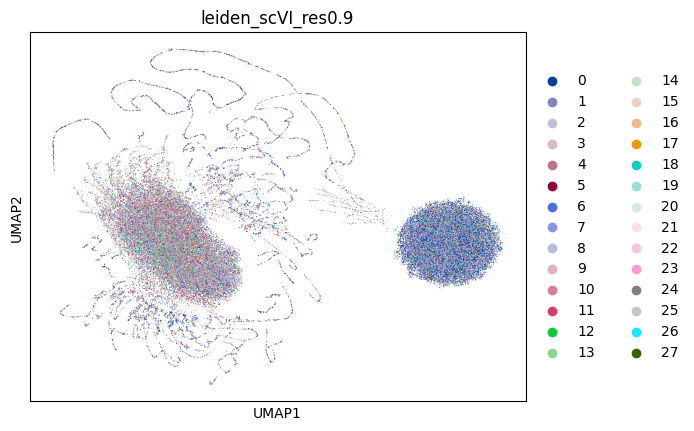

In [96]:
sc.pl.umap(train_data_2, color=['leiden_scVI_res0.9'] )

In [97]:
sc.pp.neighbors(train_data, use_rep='X_scVI')
sc.tl.umap(train_data)

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


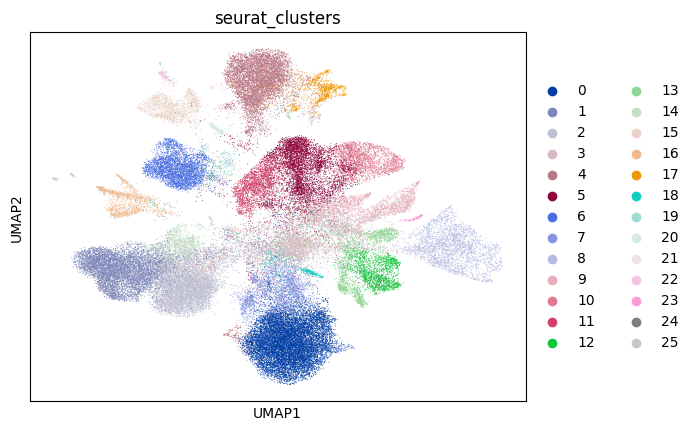

In [98]:
sc.pl.umap(train_data, color=['seurat_clusters'] )

In [60]:
#adipose_sn_ad_sp2.write_h5ad("/home/syyang/GitRepo/cs294/finalproject/script/adipose_with_VAE20270427.h5ad")

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


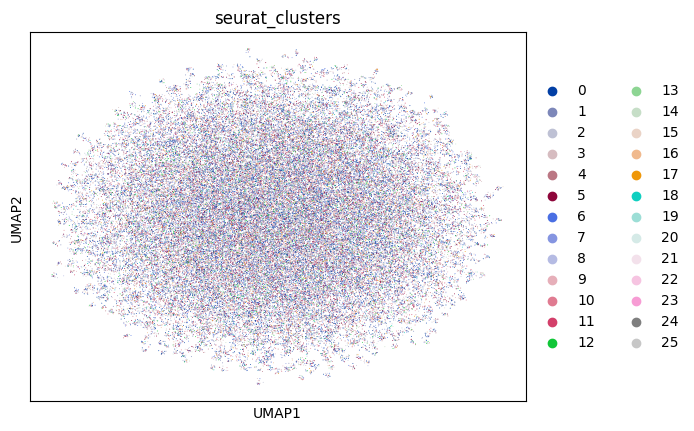

In [34]:
sc.pl.umap(adipose_sn_ad_sp2, color=['seurat_clusters'] )